In [1]:
import xarray as xr
import numpy as np

ds = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

# List of environmental variables of interest
env_vars = ["temperature", "salinity", "u_velocity", "v_velocity"]

ds

<xarray.Dataset> Size: 157GB
Dimensions:          (time: 365, dummySampleDim: 6, zc: 50, xc: 950, yc: 555)
Coordinates:
    time             (time, dummySampleDim) int32 9kB ...
  * xc               (xc) float32 4kB 800.0 1.6e+03 ... 7.592e+05 7.6e+05
  * yc               (yc) float32 2kB 800.0 1.6e+03 ... 4.432e+05 4.44e+05
  * zc               (zc) float32 200B 3.0 6.0 10.0 ... 2.5e+03 2.75e+03 3e+03
Dimensions without coordinates: dummySampleDim
Data variables:
    grid_mapping     int32 4B ...
    LayerDepths      (zc) float32 200B ...
    depth            (yc, xc) float32 2MB ...
    DXxDYy           (yc, xc) float32 2MB ...
    u_velocity       (time, zc, yc, xc) float32 38GB ...
    v_velocity       (time, zc, yc, xc) float32 38GB ...
    elevation        (time, yc, xc) float32 770MB ...
    temperature      (time, zc, yc, xc) float32 38GB ...
    salinity         (time, zc, yc, xc) float32 38GB ...
    ice_thickness    (time, yc, xc) float32 770MB ...
    ice_compactness  (time, yc, xc) float32 770MB ...
    salinity_ice     (time, yc, xc) float32 770MB ...
Attributes: (12/31)
    Conventions:                            CF-1.5
    title:                                  Current data from SINMOD
    institution:                            SINTEF Ocean
    grid_mapping:                           grid_mapping
    grid_mapping_name:                      polar_stereographic
    straight_vertical_longitude_from_pole:  58.0
    ...                                     ...
    CH:                                     0.3
    CI:                                     5.0
    icedyn:                                 F
    tidal_components:                       [0 0 0 0 0 0 0 0 0 0 0]
    history:                                Thu Nov  7 07:52:09 2024: ncrcat ...
    NCO:                                    netCDF Operators version 5.1.3 (H...

In [2]:
import time
import dask
from scipy.spatial.distance import pdist

def process_features(
    file_path,
    variable_name,
    layer_range = (0,1),
    x_range = (0,-1),
    y_range = (0,-1),
    chunks={"time":-1, "zc": -1, "yc": 50, "xc": 50},
    output_path=None
):
    """
    Process layer data for a specified variable in a NetCDF file.
    
    Parameters:
    - file_path (str): Path to the NetCDF file.
    - variable_name (str): Name of the variable to process.
    - layer_range (tuple): Range of layers to process (start, end).
    - x_range (slice, optional): Range of x coordinates to process. If None, process all.
    - output_path (str): Path to save the processed file (optional). If None, the result is not saved.
    
    Returns:
    - xarray.DataArray: The time-averaged bottom layer data.
    """
    time_start = time.time()

    # Open the dataset
    if chunks:
        ds = xr.open_dataset(file_path, chunks=chunks)
    else:
        ds = xr.open_dataset(file_path)

    print(f"\nAccessed the dataset after {time.time() - time_start:.2f} seconds")
    
    # Extract the variable
    if variable_name == "current_speed":
        data_var = (ds["u_velocity"][:, layer_range[0]:layer_range[1], y_range[0]:y_range[1], x_range[0]:x_range[1]]**2 + \
                   ds["v_velocity"][:, layer_range[0]:layer_range[1], y_range[0]:y_range[1], x_range[0]:x_range[1]]**2)**0.5
    else:
        data_var = ds[variable_name][:, layer_range[0]:layer_range[1], y_range[0]:y_range[1], x_range[0]:x_range[1]]

    # Calculate pairwise distances between points
    lon, lat = np.meshgrid(data_var["xc"].values, data_var["yc"].values)

    coordinates = np.vstack([lon.ravel(), lat.ravel()]).T

    try:
        pairwise_distances = pdist(coordinates, metric='euclidean')
    except MemoryError:
        print("Memory Error: Too many points to calculate pairwise distances")
        pairwise_distances = None
    ds.close()

    print(f"\nExtracted the layer data after {time.time() - time_start:.2f} seconds.\n\nStarting computation of statistics...")

    # Step 4: Calculate statistics across time
    # TODO: Decide on desired features
    time_avg_bottom_layer = data_var.mean(dim="time", skipna=True)
    time_percentiles = data_var.quantile([0.1,0.9], dim="time", skipna=True)

    print(f"\nComputed statistics after {time.time() - time_start:.2f} seconds")

    # Create a new DataArray with the (mean, 10th, 90th) percentiles and explicitly define the 'stat' dimension
    # Concatenate mean and percentiles in one line, drop 'quantile' and concatenate all together
    stats_array = xr.concat([time_avg_bottom_layer, time_percentiles.sel(quantile=0.1).drop_vars("quantile"), time_percentiles.sel(quantile=0.9).drop_vars("quantile")], dim="stat").rename(f"{variable_name}_features")

    # Name each value of the first dimension
    stats_array = stats_array.assign_coords(stat=["mean", "10th_percentile", "90th_percentile"])

    # Save to output file if specified
    if output_path:
        stats_array.to_netcdf(output_path)
    
    return stats_array, pairwise_distances

In [ ]:
temp_test, pairwise_dist = process_features("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc", "temperature", 
                                             x_range=(65,75), y_range=(0,10), chunks=None)

# Save as a NetCDF file
temp_array.to_netcdf("../1_data/4_interim/temperature_features_10x10_test.nc", mode="w")


Accessed the dataset after 0.01 seconds

Extracted the layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/haroldh/.conda/envs/spGDMM/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,



Computed statistics after 6.24 seconds


In [ ]:
# Create array to be transformed to biological space

temp_test = xr.open_dataset("../1_data/4_interim/temperature_features_10x10_test.nc")
salinity_test = xr.open_dataset("../1_data/4_interim/salinity_features_10x10_test.nc")

SINMOD_features_test = xr.Dataset({
    'temperature': temp_test['temperature_features'],
    'salinity': salinity_test['salinity_features']
})

# SEND TO R FOR I SPLINE 
SINMOD_features_test.to_netcdf("/cluster/home/haroldh/spGDMM/1_data/4_interim/SINMOD_features_10x10_test.nc", mode='w')

<xarray.Dataset> Size: 1kB
Dimensions:               (xc: 10, yc: 10, zc: 1, stat: 3)
Coordinates:
  * xc                    (xc) float32 40B 5.28e+04 5.36e+04 ... 5.92e+04 6e+04
  * yc                    (yc) float32 40B 800.0 1.6e+03 ... 7.2e+03 8e+03
  * zc                    (zc) float32 4B 3.0
  * stat                  (stat) <U15 180B 'mean' ... '90th_percentile'
Data variables:
    temperature_features  (stat, zc, yc, xc) float32 1kB ...

In [25]:
salinity_array, _ = process_features("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc", "salinity",
                                     chunks=None)


Accessed the dataset after 0.01 seconds
Memory Error: Too many points to calculate pairwise distances

Extracted the layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/haroldh/.conda/envs/spGDMM/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,



Computed statistics after 91.46 seconds


In [24]:
temp_array, _ = process_features("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc", "temperature", chunks=None)
temp_array


Accessed the dataset after 0.01 seconds
Memory Error: Too many points to calculate pairwise distances

Extracted the layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/haroldh/.conda/envs/spGDMM/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,



Computed statistics after 95.28 seconds


<xarray.DataArray 'temperature_features' (stat: 3, zc: 1, yc: 554, xc: 949)> Size: 6MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [ 8.95036  ,  8.95442  ,  8.950777 , ...,  8.549332 ,
           8.547776 ,  8.547671 ],
         [ 8.925162 ,  8.929397 ,  8.924648 , ...,  8.54698  ,
           8.545511 ,  8.545669 ],
         [ 8.9004345,  8.902989 ,  8.898687 , ...,  8.544727 ,
           8.543233 ,  8.543532 ]]],


       [[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
...
           6.794153 ,  6.79574  ],
         [ 7.172009 ,  7.1859736,  7.1726437, ...,  6.794629 ,
           6.798914 ,  6.7966924],
         [ 7.078536 ,  7.088216 ,  7.0767903, ...,  6.797803 ,
           6.791138 ,  6.796375 ]]],


       [[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [11.117356 , 11.117356 , 11.11688  , ..., 10.9059725,
          10.901688 , 10.900101 ],
         [11.131639 , 11.131639 , 11.131798 , ..., 10.9070835,
          10.903275 , 10.901529 ],
         [11.120688 , 11.122593 , 11.122593 , ..., 10.905497 ,
          10.904861 , 10.903116 ]]]], dtype=float32)
Coordinates:
  * xc       (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.584e+05 7.592e+05
  * yc       (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.424e+05 4.432e+05
  * zc       (zc) float32 4B 3.0
  * stat     (stat) <U15 180B 'mean' '10th_percentile' '90th_percentile'

In [51]:
SINMOD_features = xr.Dataset({
    'temperature': temp_array,
    'salinity': salinity_array
})

#SINMOD_features.sel(stat="mean", xc=574, yc=122)
SINMOD_features = SINMOD_features.squeeze('zc', drop=True)


SINMOD_features['stat'].values

array(['mean', '10th_percentile', '90th_percentile'], dtype='<U15')

In [135]:
SINMOD_features.to_netcdf("/cluster/home/haroldh/spGDMM/1_data/4_interim/SINMOD_features.nc", mode='w')

In [59]:
# Get training data at sample locations 
sampled_locations = pd.read_csv("/cluster/home/haroldh/spGDMM/1_data/1_raw/synthetic_abundance/sampled_locations.csv")

# Initialize an empty list to store the results
results = np.empty((len(sampled_locations), len(SINMOD_features.data_vars) * len(SINMOD_features['stat'].values)))

print(results.shape)

for i, row in sampled_locations.iterrows():
    x = row['x']
    y = row['y']
    j=0
    for var in SINMOD_features.data_vars:
        for stat in SINMOD_features['stat'].values:

            # Use the values for selection
            results[i,j] = SINMOD_features[var].isel(xc=x, yc=y).sel(stat=stat).values
            
            j+=1
            
            # Save results to a CSV file

# Generate column names
column_names = [f"{var}_{stat}" for var in SINMOD_features.data_vars for stat in SINMOD_features['stat'].values]

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=column_names)

# Save results to a CSV file
results_df.to_csv("/cluster/home/haroldh/spGDMM/1_data/2_processed/training/midnor_training.csv", index=False)


(10, 6)


In [136]:
import pandas as pd
# Get from R and then transform to biological space
X_GDM_predictors_bs = pd.read_csv("/cluster/home/haroldh/spGDMM/1_data/2_processed/prediction/X_GDM_predictors_bs.csv")

# Get beta values
beta_posts = pd.read_csv("/cluster/home/haroldh/spGDMM/4_trained_models/mod1_SINMOD_post_samples.csv")

beta_posts = beta_posts.drop(columns=['Unnamed: 0'])

In [137]:
beta_posts.columns

Index(['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'beta[6]',
       'beta[7]', 'beta[8]', 'beta[9]', 'beta[10]', 'beta[11]', 'beta[12]',
       'beta[13]', 'beta[14]', 'beta[15]', 'beta[16]', 'beta[17]', 'beta[18]',
       'beta[19]', 'beta[20]', 'beta[21]', 'beta[22]', 'beta[23]', 'beta[24]',
       'beta[25]', 'beta[26]', 'beta[27]', 'beta[28]', 'beta_0', 'log_beta[1]',
       'log_beta[2]', 'log_beta[3]', 'log_beta[4]', 'log_beta[5]',
       'log_beta[6]', 'log_beta[7]', 'log_beta[8]', 'log_beta[9]',
       'log_beta[10]', 'log_beta[11]', 'log_beta[12]', 'log_beta[13]',
       'log_beta[14]', 'log_beta[15]', 'log_beta[16]', 'log_beta[17]',
       'log_beta[18]', 'log_beta[19]', 'log_beta[20]', 'log_beta[21]',
       'log_beta[22]', 'log_beta[23]', 'log_beta[24]', 'log_beta[25]',
       'log_beta[26]', 'log_beta[27]', 'log_beta[28]', 'sigma2'],
      dtype='object')

In [138]:
X_GDM_predictors_bs.shape

(525746, 24)

In [139]:
weighted_X_GDM_bs = X_GDM_predictors_bs * beta_posts.mean(axis=0)[25:49].values # OR MEDIAN OR WHATEVER

# Step 2: Sum every 4 columns (assuming 4 bases per feature)
n_grids, n_bases = weighted_X_GDM_bs.shape
num_bases_per_feature = 4
num_features = n_bases // num_bases_per_feature

reshaped = np.reshape(weighted_X_GDM_bs, (n_grids, num_features, num_bases_per_feature))

# Step 2: Sum along the I-spline basis axis (axis=2)
collapsed_X_GDM = reshaped.sum(axis=2)

In [140]:
# Compute the row-wise sums of the original and collapsed arrays, ignoring NaNs
original_sums = np.nansum(weighted_X_GDM_bs, axis=1)
collapsed_sums = np.nansum(collapsed_X_GDM, axis=1)

# Compare the two
if np.allclose(original_sums, collapsed_sums, atol=1e-8):
    print("The row-wise sums match! The collapsing process is correct.")
else:
    print("Mismatch detected in row-wise sums.")
    print("Original sums:", original_sums)
    print("Collapsed sums:", collapsed_sums)
    print("Difference:", original_sums - collapsed_sums)


The row-wise sums match! The collapsing process is correct.


In [141]:
from sklearn.decomposition import PCA

collapsed_X_GDM_no_nan = collapsed_X_GDM[~np.isnan(collapsed_X_GDM).any(axis=1)]

# Perform PCA
pca = PCA(n_components=3)
collapsed_X_GDM_pca = pca.fit_transform(collapsed_X_GDM_no_nan)

# Print the explained variance ratio of the top 3 components
print("Explained variance ratio of the top 3 components:", pca.explained_variance_ratio_)

# Print the transformed data
print("Transformed data (top 3 principal components):")
print(collapsed_X_GDM_pca)

Explained variance ratio of the top 3 components: [0.73998074 0.16779657 0.07160847]
Transformed data (top 3 principal components):
[[10.35384802 -3.36005123 -5.94408873]
 [10.38641839 -3.38335041 -5.95155407]
 [10.4121751  -3.40565844 -5.98760992]
 ...
 [-4.98177155  5.91191548  0.32058202]
 [-4.98736511  5.92043451  0.30887214]
 [-4.99789559  5.91611631  0.31974986]]


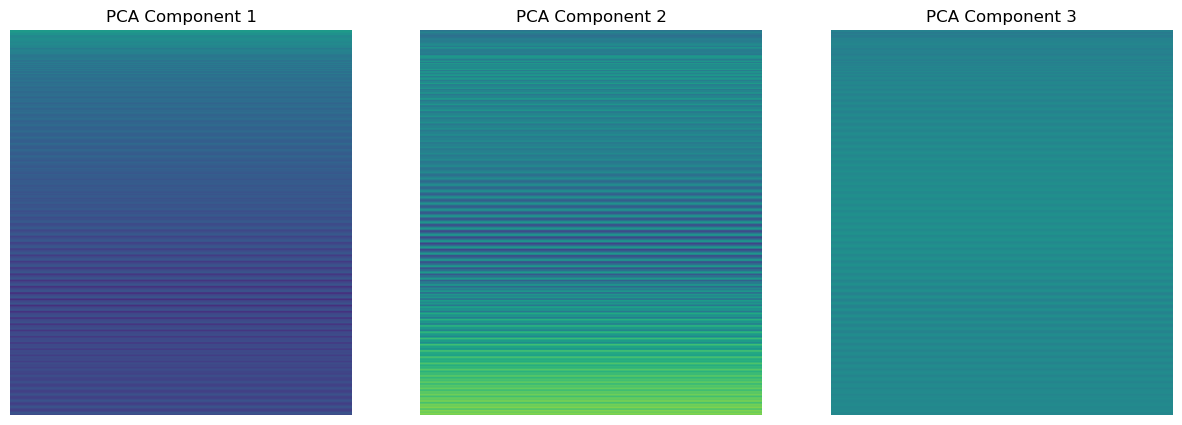

In [142]:
import matplotlib.pyplot as plt

# Normalize the PCA data to the range [0, 1] for RGB plotting
normalized_pca = (collapsed_X_GDM_pca - collapsed_X_GDM_pca.min(axis=0)) / (collapsed_X_GDM_pca.max(axis=0) - collapsed_X_GDM_pca.min(axis=0))

# Plot each column as an RGB image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(normalized_pca[:, i].reshape(-1, 1), aspect='auto', cmap='viridis')
    ax.set_title(f'PCA Component {i+1}')
    ax.axis('off')



plt.show()